/root/miniconda3/envs/dino_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/miniconda3/envs/dino_env/lib/python3.10/site-packages/diffusers/pipelines/pipeline_loading_utils.py:219: FutureWarning: You are loading the variant fp16 from CompVis/stable-diffusion-v1-4 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
text_encoder/model.safetensors not found
Loading pipeline components...:  14%|█▍        | 1/7 [00:00<00:00,  6.48it/s]An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/vae: Error no file named diffusion_pytorch_

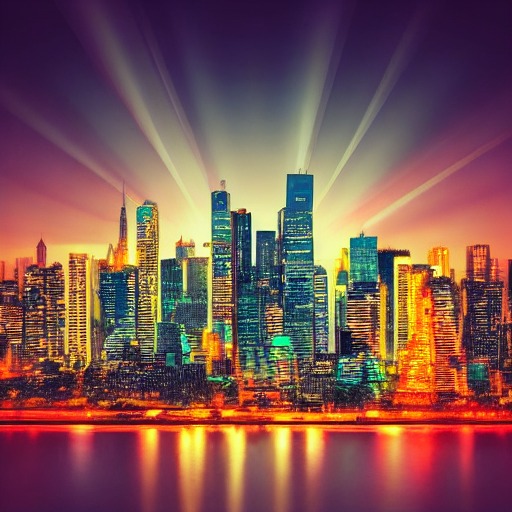

In [1]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
import json
import matplotlib.pyplot as plt
import os

# Define the model repository; here we use the popular Stable Diffusion v1.4
model_id = "CompVis/stable-diffusion-v1-4"

# Load the DDPM scheduler from the model repository
# Note: The 'subfolder="scheduler"' assumes that the model repo contains a scheduler config.
scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")

# Create the Stable Diffusion pipeline with the DDPM scheduler
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    scheduler=scheduler,       # Inject the DDPM scheduler
    revision="fp16",           # Use the fp16 model weights if available for speed
    torch_dtype=torch.float16
)

# Move the pipeline to GPU if available
pipe.to("cuda")

# Define a text prompt
prompt = "A futuristic cityscape at dusk with neon lights"

# Generate an image from the prompt
result = pipe(prompt, num_inference_steps=50)
image = result.images[0]

# Display the image
image.show()


In [2]:
def show_images_grid(images, rows, cols, figsize=(10, 10)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i])
            ax.axis("off")  # Hide axes
        else:
            ax.set_visible(False)  # Hide empty subplots

    plt.tight_layout()
    plt.show()

In [3]:
from PIL import Image
from tqdm import tqdm
from IPython.display import clear_output
import numpy as np
from torchvision import transforms
import torchvision.transforms.functional as TF
import cv2
import torch.nn as nn

mask = transforms.ToTensor()(cv2.imread("/job/processed_data/cat/cat003_mask.jpg", cv2.IMREAD_GRAYSCALE) > 40)
mask = TF.resize(mask, (520, 520), interpolation=TF.InterpolationMode.BILINEAR)
plt.imshow(mask.permute(1, 2, 0))

In [4]:
from torchvision.models.segmentation import lraspp_mobilenet_v3_large, LRASPP_MobileNet_V3_Large_Weights

criterion = nn.CrossEntropyLoss()
segmentator = lraspp_mobilenet_v3_large(LRASPP_MobileNet_V3_Large_Weights.DEFAULT).to("cuda:1")

/root/miniconda3/envs/dino_env/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


## Forward pass with the s(t) that they propose in the paper

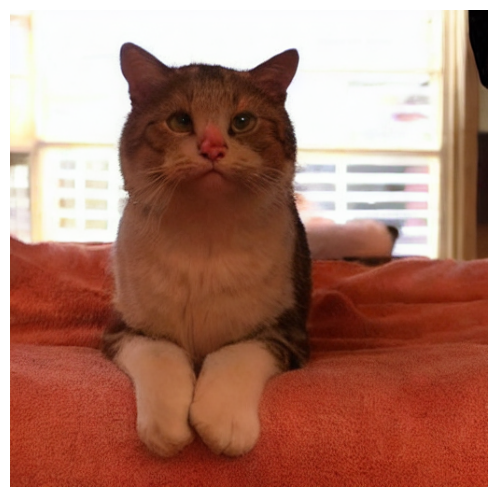

100%|██████████| 500/500 [24:50<00:00,  2.98s/it]


In [7]:
device="cuda:0"
output_type = "pil"
guidance_scale = 1.5

height = pipe.unet.config.sample_size * pipe.vae_scale_factor
width = pipe.unet.config.sample_size * pipe.vae_scale_factor

num_images = 1

with torch.no_grad():
    prompt_embeds = pipe._encode_prompt(
        "The image features a cat sitting on a bed, which is covered with a white blanket. The cat is positioned in the center of the bed, looking directly at the camera. The cat appears to be a calico, with a mix of brown, black, and white fur. The bed is situated in a room with a couch in the background, and a chair can be seen nearby.",
        device,
        num_images_per_prompt=num_images,
        do_classifier_free_guidance=True,
        negative_prompt=None,
        prompt_embeds=None,
        negative_prompt_embeds=None,
        lora_scale=None,
    )

# 4. Prepare timesteps
num_inference_steps = 500
pipe.scheduler.set_timesteps(num_inference_steps, device=device)
timesteps = pipe.scheduler.timesteps

# 5. Prepare latent variables
num_channels_latents = pipe.unet.config.in_channels
latents = pipe.prepare_latents(
    num_images,
    num_channels_latents,
    height,
    width,
    prompt_embeds.dtype,
    device,
    generator=None,
    latents=None,
)
latents.requires_grad_(False)

trans = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

k = 10
m = 10
# 7. Denoising loop
for i, t in tqdm(enumerate(timesteps), total=num_inference_steps):
    for _ in range(k):
        z_t = latents.detach().clone()
        z_t.requires_grad_(True)
        latent_model_input = z_t.repeat(2, 1, 1, 1) # classifier free guidance
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        # with torch.no_grad():
        pipe.unet.zero_grad()
        noise_pred = pipe.unet(
            latent_model_input,
            t,
            encoder_hidden_states=prompt_embeds,
            cross_attention_kwargs=None,
            return_dict=False,
        )[0]

        # classifier free guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        alpha_prod_t = pipe.scheduler.alphas_cumprod[timesteps[i]]
        alpha_prod_t_prev = pipe.scheduler.alphas_cumprod[timesteps[i + 1]] if i + 1 < len(timesteps) else torch.tensor(1.0)


        # todo
        pipe.vae.zero_grad()
        segmentator.zero_grad()

        z_zero = (z_t - (1 - alpha_prod_t) ** 0.5 * noise_pred) / alpha_prod_t ** 0.5

        img = pipe.vae.decode(z_zero / pipe.vae.config.scaling_factor, return_dict=False)[0]
        map = (img + 1) * 0.5
        map = TF.resize(map, (520, 520), interpolation=TF.InterpolationMode.BILINEAR)
        map = trans(map)

        seg_logits = segmentator(map.to("cuda:1").float())['out']

        class8_logits = seg_logits[:, 8, :, :]

        loss = torch.nn.functional.binary_cross_entropy_with_logits(class8_logits, mask.to("cuda:1").expand(num_images, 520, 520).float())

        loss.backward()
        noise_pred += 400 * (1 - alpha_prod_t) * z_t.grad

        # compute the previous noisy sample x_t -> x_t-1
        next_latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample
        latents = (alpha_prod_t/alpha_prod_t_prev)**0.5 * next_latents \
            + (1 - alpha_prod_t/alpha_prod_t_prev)**0.5 * torch.randn_like(next_latents)
    latents = next_latents


    with torch.no_grad():
        plt.close()
        clear_output()
        image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False)[0]
        images = pipe.image_processor.postprocess(image.detach(), output_type=output_type, do_denormalize=[True] * num_images)
        show_images_grid(images, rows=2, cols=2)

### Let's visualize how image is related with initial mask

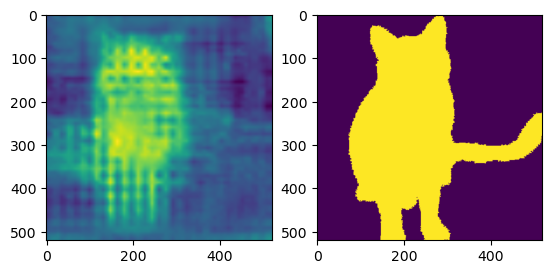

In [8]:
with torch.no_grad():
    img = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False)[0]


map = (img + 1) * 0.5
map = TF.resize(map, (520, 520), interpolation=TF.InterpolationMode.BILINEAR)
trans = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
map = trans(map)

plt.subplot(1, 2, 1)
plt.imshow(segmentator(map.to("cuda:1").float())["out"][0, 8].detach().cpu())
plt.subplot(1, 2, 2)
plt.imshow(mask[0])



It is seen that we capture some information from the guidance, but we lose the cat's tail and thin details. Of course, because we actually guide the latent representation that we pass to VAE instead of the image itself, thus our guidance is not very precise

Let's true increase S(t) in the beginning

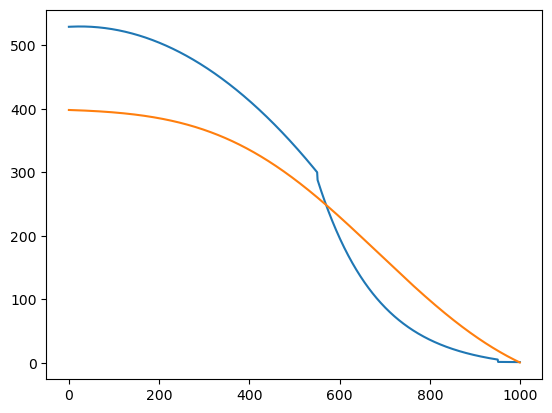

In [147]:
import numpy as np

#exp on different schedule

def custom_mapping(x):
    """
    Maps integers [1, 999] into a function in range [0, 400] with the specified properties:
    - f(1) = 400
    - f(999) = 0
    - Slow decrease from 1 to 700
    - Fast decrease from 700 to 900
    - Almost no change from 900 to 999
    """
    x = np.clip(x, 1, 999)  # Ensure x is within the range
    if x <= 550:
        return (-(x + 500) * (x - 550)/ 1200 + 300)   # Quadratic decay (slow)
    elif x <= 950:
        return 300 * np.exp(-1.5 * (x - 550) / 200) - 10  # Exponential decay (fast)
    else:
        return 300 * np.exp(-4) * (1 - 0.1 * (x - 900) / 99) - 4  # Almost constant


x_values = np.arange(0, 1000)
y_values = np.array([custom_mapping(x) for x in x_values])

plt.plot(y_values)
plt.plot(400 * (1 - pipe.scheduler.alphas_cumprod.cpu().numpy()[::-1]))

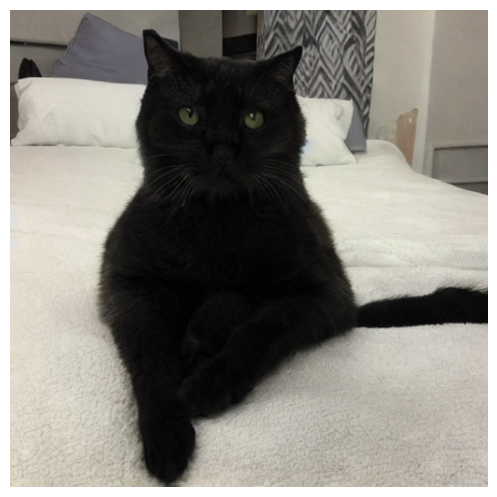

100%|██████████| 500/500 [24:55<00:00,  2.99s/it]


In [148]:
from tqdm import tqdm
from IPython.display import clear_output

import torch
import numpy as np

device="cuda:0"
output_type = "pil"
guidance_scale = 1.5

height = pipe.unet.config.sample_size * pipe.vae_scale_factor
width = pipe.unet.config.sample_size * pipe.vae_scale_factor

num_images = 1

with torch.no_grad():
    prompt_embeds = pipe._encode_prompt(
        "The image features a cat sitting on a bed, which is covered with a white blanket. The cat is positioned in the center of the bed, looking directly at the camera. The cat appears to be a calico, with a mix of brown, black, and white fur. The bed is situated in a room with a couch in the background, and a chair can be seen nearby.",
        device,
        num_images_per_prompt=num_images,
        do_classifier_free_guidance=True,
        negative_prompt=None,
        prompt_embeds=None,
        negative_prompt_embeds=None,
        lora_scale=None,
    )

# 4. Prepare timesteps
num_inference_steps = 500
pipe.scheduler.set_timesteps(num_inference_steps, device=device)
timesteps = pipe.scheduler.timesteps

# 5. Prepare latent variables
num_channels_latents = pipe.unet.config.in_channels
latents = pipe.prepare_latents(
    num_images,
    num_channels_latents,
    height,
    width,
    prompt_embeds.dtype,
    device,
    generator=None,
    latents=None,
)
latents.requires_grad_(False)

trans = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

s_schedule = np.flip(y_values)

k = 10
m = 10
# 7. Denoising loop
for i, t in tqdm(enumerate(timesteps), total=num_inference_steps):
    for _ in range(k):
        z_t = latents.detach().clone()
        z_t.requires_grad_(True)
        latent_model_input = z_t.repeat(2, 1, 1, 1) # classifier free guidance
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        # with torch.no_grad():
        pipe.unet.zero_grad()
        noise_pred = pipe.unet(
            latent_model_input,
            t,
            encoder_hidden_states=prompt_embeds,
            cross_attention_kwargs=None,
            return_dict=False,
        )[0]

        # classifier free guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        alpha_prod_t = pipe.scheduler.alphas_cumprod[timesteps[i]]
        alpha_prod_t_prev = pipe.scheduler.alphas_cumprod[timesteps[i + 1]] if i + 1 < len(timesteps) else torch.tensor(1.0)


        # todo
        pipe.vae.zero_grad()
        segmentator.zero_grad()

        z_zero = (z_t - (1 - alpha_prod_t) ** 0.5 * noise_pred) / alpha_prod_t ** 0.5

        img = pipe.vae.decode(z_zero / pipe.vae.config.scaling_factor, return_dict=False)[0]
        map = (img + 1) * 0.5
        map = TF.resize(map, (520, 520), interpolation=TF.InterpolationMode.BILINEAR)
        map = trans(map)

        seg_logits = segmentator(map.to("cuda:1").float())['out']

        class8_logits = seg_logits[:, 8, :, :]

        loss = torch.nn.functional.binary_cross_entropy_with_logits(class8_logits, mask.to("cuda:1").expand(num_images, 520, 520).float())

        loss.backward()
        noise_pred += s_schedule[t] * z_t.grad

        # compute the previous noisy sample x_t -> x_t-1
        next_latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample
        latents = (alpha_prod_t/alpha_prod_t_prev)**0.5 * next_latents \
            + (1 - alpha_prod_t/alpha_prod_t_prev)**0.5 * torch.randn_like(next_latents)
    latents = next_latents


    with torch.no_grad():
        plt.close()
        clear_output()
        image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False)[0]
        images = pipe.image_processor.postprocess(image.detach(), output_type=output_type, do_denormalize=[True] * num_images)
        show_images_grid(images, rows=2, cols=2)

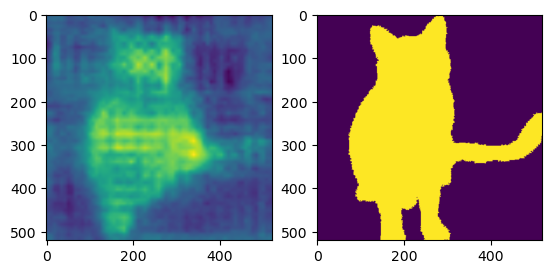

In [151]:
with torch.no_grad():
    img = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False)[0]


map = (img + 1) * 0.5
map = TF.resize(map, (520, 520), interpolation=TF.InterpolationMode.BILINEAR)
trans = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
map = trans(map)

plt.subplot(1, 2, 1)
plt.imshow(segmentator(map.to("cuda:1").float())["out"][0, 8].detach().cpu())
plt.subplot(1, 2, 2)
plt.imshow(mask[0])



Looks more guided, but now the cat is fully black, which is not in the textual prompt